### Assessment of HPF performance

In [161]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import loompy
import cytograph as cg
import cytograph.plotting as cgplot
import scipy.sparse as sparse
from scipy.stats import chi2, entropy
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [117]:

def poisson_interval(k, alpha=0.05): 
    """
    uses chisquared info to get the poisson interval. Uses scipy.stats 
    (imports in function). 
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    low[k==0] = 0
    return low, high

In [118]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [192]:
d = "/Users/stelin/cytograph/mouse_dev_20190528/data/"
f = "CortexP7_Filtered"
main_layer = ""
n_threads = 8
n_selected = 1000

In [193]:
with loompy.connect(d + f + ".loom") as ds:
    n_genes, n_cells = ds.shape
    n_clusters = ds.ca.Clusters.max() + 1
    labels = ds.ca.Clusters
    print(f"'{f}' has {n_genes} genes and {n_cells} cells in {n_clusters} clusters")

'CortexP7_Filtered' has 31053 genes and 4825 cells in 44 clusters


### HPF predictive value
Run HPF using increasing number of components, and assess PPV

In [194]:
with loompy.connect(d + f + ".loom") as ds:
    genes = cg.FeatureSelectionByEnrichment(n_selected // n_clusters, cg.Species.mask(ds, ["cellcycle", "sex", "ieg", "mt"]), findq=False).select(ds)
    sdata = ds[main_layer].sparse(rows=genes).T
    data = sdata.toarray()

In [195]:
hpfs = {}
for n_factors in [2, 4, 8, 16, 32, 64, 128, 256]:
    hpfs[n_factors] = cg.HPF(k=n_factors, validation_fraction=0.05, min_iter=40, max_iter=200, compute_X_ppv=True, n_threads=n_threads)
    hpfs[n_factors].fit(sdata)

HPF (nnz=314,199):  20%|█▉        | 40/201 [03:37<07:58,  2.97s/it, diff=-0.00361, ll=-7e+04]  


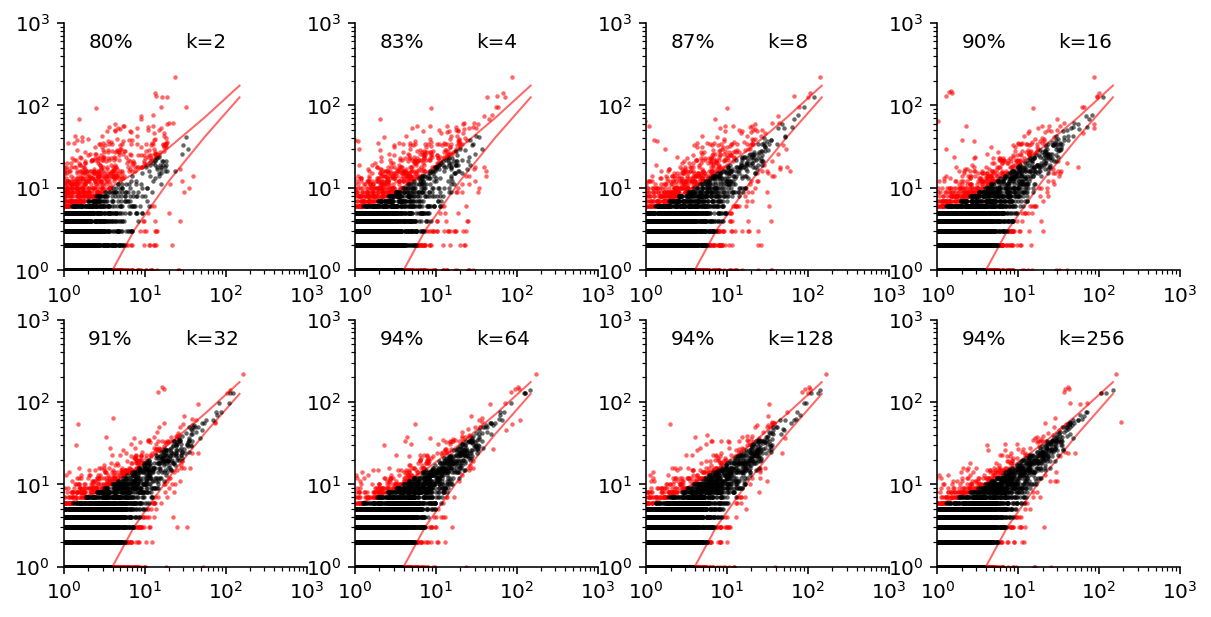

In [196]:
plt.figure(figsize=(10, 5))
cells = np.random.choice(n_cells, replace=False, size=200)
xmin = None
xmax = None
ymin = None
ymax = None
for i, k in enumerate(hpfs.keys()):
    hpf = hpfs[k]
    x = hpf.X_ppv[cells, :]
    y = data[cells, :]
    xmax = x.max() if xmax is None else max(xmax, x.max())
    ymax = y.max() if ymax is None else max(ymax, y.max())
    
for i, k in enumerate(sorted(hpfs.keys())):
    hpf = hpfs[k]
    ax = plt.subplot(2, 4, i + 1)
    x = hpf.X_ppv[cells, :]
    ci1, ci2 = poisson_interval(x)
    y = data[cells, :]
    y_inside = ((y >= ci1) & (y <= ci2))
    plt.scatter(x[~y_inside], y[~y_inside], marker='.', lw=0, alpha=0.6,c="red",s=20)
    plt.scatter(x[y_inside], y[y_inside], marker='.', lw=0, alpha=0.6,c="black",s=20,zorder=10)
    xp = np.exp(np.arange(np.log(xmax + 1)))
    xpup, xpdn = poisson_interval(xp)
    plt.plot(xp, xpup, c='red', linestyle='-', lw=1, alpha=0.6)
    plt.plot(xp, xpdn, c='red', linestyle='-', lw=1, alpha=0.6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlim((1, 1000))
    plt.ylim((1, 1000))
    plt.text(0.5, 0.9, f"k={k}", transform=ax.transAxes)
    pct_inside = 100 * y_inside[y > 1].sum() // y[y > 1].size
    plt.text(0.1, 0.9, f"{pct_inside}%", transform=ax.transAxes)
plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/HPF_assessment.pdf",dpi=144, bbox_inches='tight')

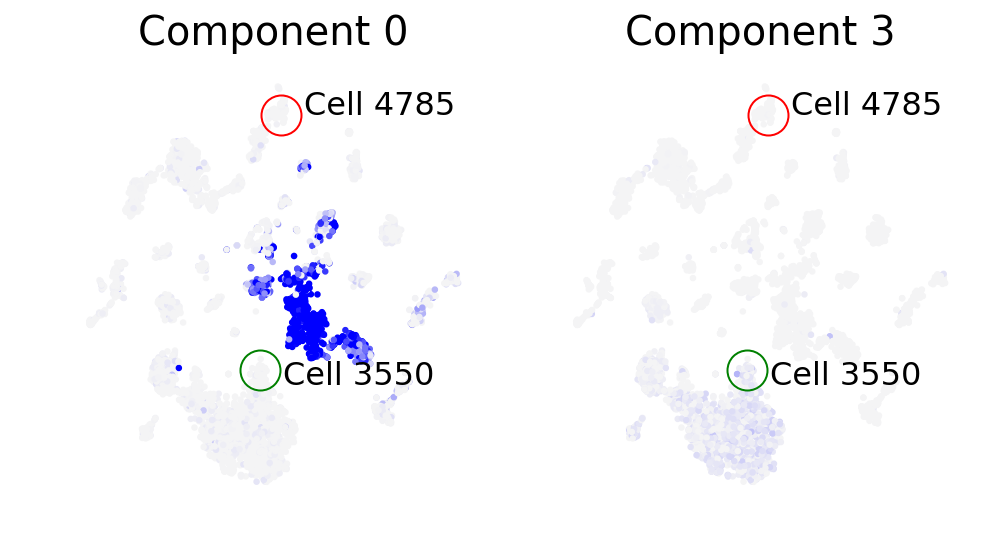

In [197]:
with loompy.connect(d + f + ".loom") as ds:
    # 4785, 3550
    plt.figure(figsize=(8, 4))
    hpf = hpfs[64]
    ax=plt.subplot(121)
    norm = MidpointNormalize(midpoint=0)
    vcmap = LinearSegmentedColormap.from_list("", ["red","whitesmoke","blue"])
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],vmin=0,vmax=50,c=hpf.theta[:,0],s=5,cmap=vcmap, norm=norm)
    plt.plot(ds.ca.TSNE[4785, 0], ds.ca.TSNE[4785, 1], marker="o", ms=20,mfc="none",c="red")
    plt.plot(ds.ca.TSNE[3550, 0], ds.ca.TSNE[3550, 1], marker="o", ms=20,mfc="none",c="green")
    plt.text(ds.ca.TSNE[4785, 0] + 10, ds.ca.TSNE[4785, 1], "Cell 4785", size=16)
    plt.text(ds.ca.TSNE[3550, 0] + 10, ds.ca.TSNE[3550, 1] - 5, "Cell 3550", size=16)
    plt.text(0.5, 1.05, "Component 0", ha="center", transform=ax.transAxes, size=20)
    plt.axis("off")
    ax=plt.subplot(122)
    norm = MidpointNormalize(midpoint=0)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],vmin=0,vmax=500,c=hpf.theta[:,3],s=5,cmap=vcmap, norm=norm)
    plt.axis("off")
    plt.plot(ds.ca.TSNE[4785, 0], ds.ca.TSNE[4785, 1], marker="o", ms=20,mfc="none",c="red")
    plt.plot(ds.ca.TSNE[3550, 0], ds.ca.TSNE[3550, 1], marker="o", ms=20,mfc="none",c="green")
    plt.text(ds.ca.TSNE[4785, 0] + 10, ds.ca.TSNE[4785, 1], "Cell 4785", size=16)
    plt.text(ds.ca.TSNE[3550, 0] + 10, ds.ca.TSNE[3550, 1] - 5, "Cell 3550", size=16)
    plt.text(0.5, 1.05, "Component 3", ha="center", transform=ax.transAxes, size=20)
    plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/HPF_examples.pdf",dpi=144, bbox_inches='tight')

['Klhl1' 'Ptprk' 'Met' 'Ccbe1' 'Npnt']
['Ctsc' 'Pla2g7' 'Cldn10' 'Vcam1' 'Mfge8']
['Helt' 'Ascl1' 'Mgarp' 'Prss23' 'Dll1']
['Daam2' 'Dio2' 'Slco1c1' 'Gjb6' 'Slc7a10']
['Neil3' 'Tk1' 'Hist1h1b' 'Pclaf' 'Kif15']
['Tnc' 'Rhcg' 'Papss2' 'Islr' 'Gm14964']


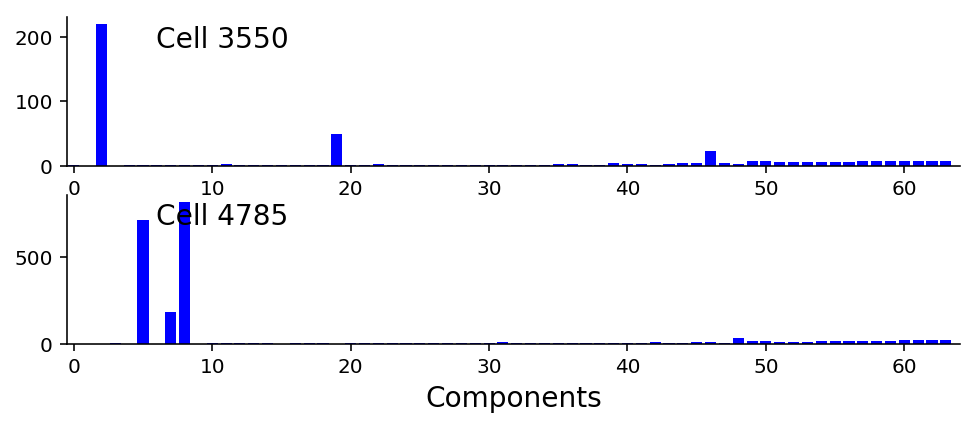

In [198]:
with loompy.connect(d + f + ".loom") as ds:
    # 4785, 3550
    hpf = hpfs[64]
    beta_norm = (hpf.beta.T / hpf.beta.sum(axis=1)).T
    gene_names = ds.ra.Gene[np.where(genes)[0]]
    plt.figure(figsize=(8, 3))
    ax=plt.subplot(211)
    plt.bar(np.arange(64), hpf.theta[3550, :], color="blue")
    print(gene_names[np.argsort(-beta_norm[:, 0])][:5])
    print(gene_names[np.argsort(-beta_norm[:, 2])][:5])
    print(gene_names[np.argsort(-beta_norm[:, 26])][:5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))
    plt.xlim(-0.5,64)
    plt.text(0.1, 0.8, "Cell 3550", transform=ax.transAxes, size=14)
    ax=plt.subplot(212)
    plt.bar(np.arange(64), hpf.theta[4785, :],color="blue")
    print(gene_names[np.argsort(-beta_norm[:, 3])][:5])
    print(gene_names[np.argsort(-beta_norm[:, 9])][:5])
    print(gene_names[np.argsort(-beta_norm[:, 15])][:5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))
    plt.xlabel("Components", size=14)
    plt.xlim(-0.5,64)
    plt.text(0.1, 0.8, "Cell 4785", transform=ax.transAxes, size=14)
    plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/HPF_cells.pdf",dpi=144, bbox_inches='tight')

In [199]:
with loompy.connect(d + f + ".loom") as ds:
    pcas = {}
    for n_factors in [2, 4, 8, 16, 32, 64, 128, 256]:
        print(n_factors)
        pcas[n_factors] = cg.PCAProjection(genes=genes, max_n_components=n_factors, layer=main_layer)
        pcas[n_factors].fit(ds)

2
4
8
16
32
64
128
256


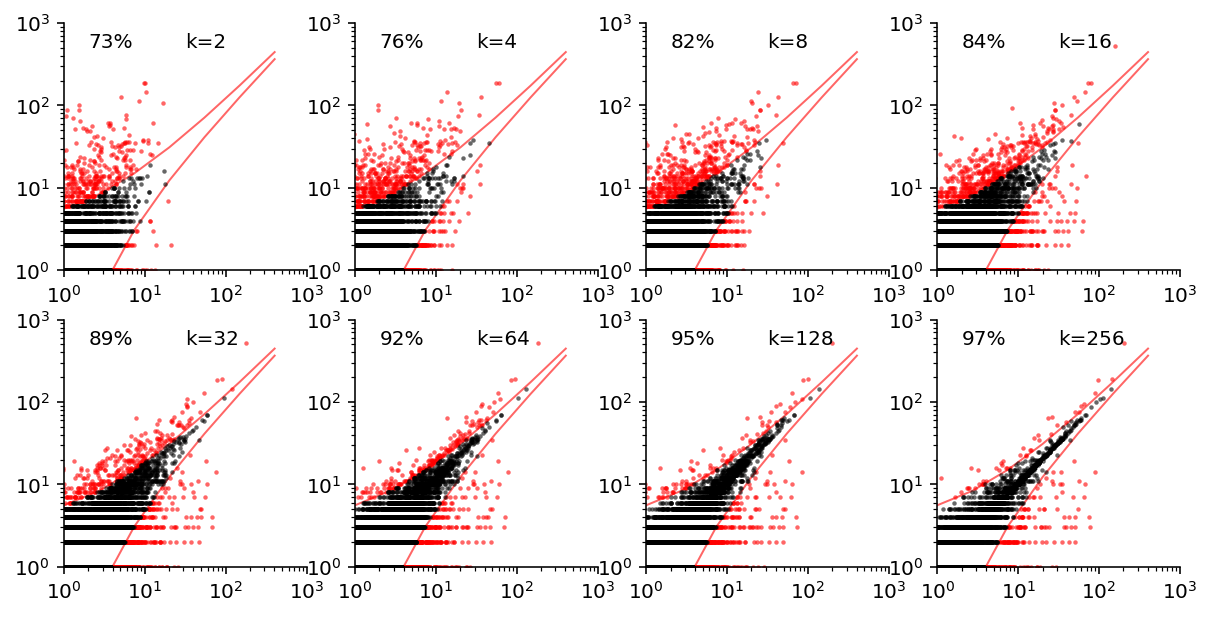

In [200]:
plt.figure(figsize=(10, 5))
cells = np.random.choice(n_cells, replace=False, size=200)
xmin = None
xmax = None
ymin = None
ymax = None
for i, k in enumerate(pcas.keys()):
    pca = pcas[k]
    x = (np.dot(pca.pca.transform(data), pca.pca.components_) + pca.pca.mean_)
    y = data[cells,:]
    xmax = x.max() if xmax is None else max(xmax, x.max())
    ymax = y.max() if ymax is None else max(ymax, y.max())
    
for i, k in enumerate(sorted(pcas.keys())):
    pca = pcas[k]
    ax = plt.subplot(2, 4, i + 1)
    x = (np.dot(pca.pca.transform(data), pca.pca.components_) + pca.pca.mean_)[cells,:]
    x[x < 0] = 0
    ci1, ci2 = poisson_interval(x)
    y = data[cells,:]
    y_inside = ((y >= ci1) & (y <= ci2))
    plt.scatter(x[~y_inside], y[~y_inside], marker='.', lw=0, alpha=0.6,c="red",s=20)
    plt.scatter(x[y_inside], y[y_inside], marker='.', lw=0, alpha=0.6,c="black",s=20,zorder=10)
    xp = np.exp(np.arange(np.log(xmax + 1)))
    xpup, xpdn = poisson_interval(xp)
    plt.plot(xp, xpup, c='red', linestyle='-', lw=1, alpha=0.6)
    plt.plot(xp, xpdn, c='red', linestyle='-', lw=1, alpha=0.6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlim((1, 1000))
    plt.ylim((1, 1000))
    plt.text(0.5, 0.9, f"k={k}", transform=ax.transAxes)
    pct_inside = 100 * y_inside[y > 1].sum() // y[y > 1].size
    plt.text(0.1, 0.9, f"{pct_inside}%", transform=ax.transAxes)
plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/PCA_assessment.pdf",dpi=144, bbox_inches='tight')

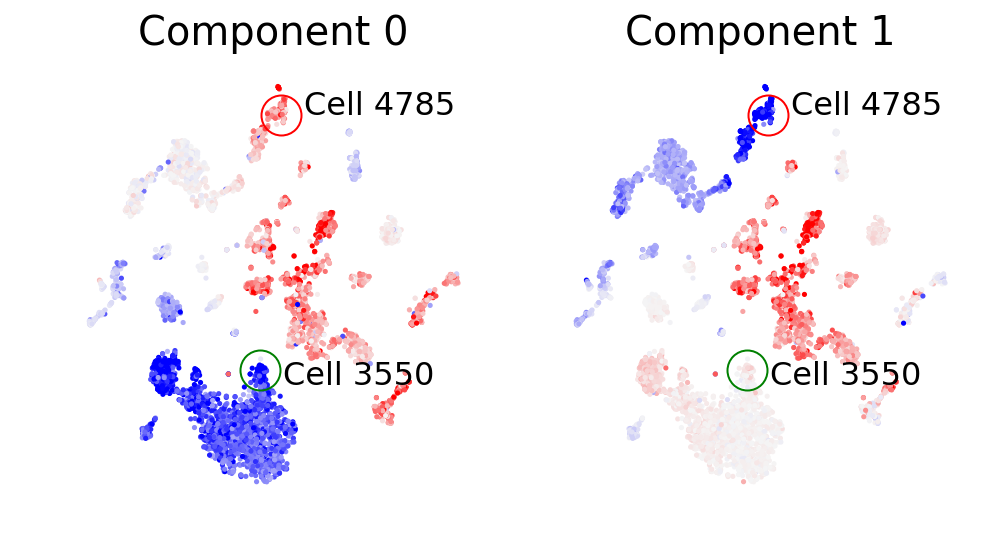

In [201]:
with loompy.connect(d + f + ".loom") as ds:
    plt.figure(figsize=(8, 4))
    pca = pcas[64]
    norm = MidpointNormalize(midpoint=0)
    vcmap = LinearSegmentedColormap.from_list("", ["red","whitesmoke","blue"])
    ax=plt.subplot(121)
    z = pca.pca.transform(data)[:,0]
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],vmin=-20,vmax=30,c=z,s=2.5, norm=norm, cmap=vcmap)
    plt.plot(ds.ca.TSNE[4785, 0], ds.ca.TSNE[4785, 1], marker="o", ms=20,mfc="none",c="red")
    plt.plot(ds.ca.TSNE[3550, 0], ds.ca.TSNE[3550, 1], marker="o", ms=20,mfc="none",c="green")
    plt.text(ds.ca.TSNE[4785, 0] + 10, ds.ca.TSNE[4785, 1], "Cell 4785", size=16)
    plt.text(ds.ca.TSNE[3550, 0] + 10, ds.ca.TSNE[3550, 1] - 5, "Cell 3550", size=16)
    plt.text(0.5, 1.05, "Component 0", ha="center", transform=ax.transAxes, size=20)
    plt.axis("off")
    ax=plt.subplot(122)
    norm = MidpointNormalize(midpoint=0)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],vmin=-20,vmax=30,c=pca.pca.transform(data)[:,1],s=2.5, norm=norm, cmap=vcmap)
    plt.plot(ds.ca.TSNE[4785, 0], ds.ca.TSNE[4785, 1], marker="o", ms=20,mfc="none",c="red")
    plt.plot(ds.ca.TSNE[3550, 0], ds.ca.TSNE[3550, 1], marker="o", ms=20,mfc="none",c="green")
    plt.text(ds.ca.TSNE[4785, 0] + 10, ds.ca.TSNE[4785, 1], "Cell 4785", size=16)
    plt.text(ds.ca.TSNE[3550, 0] + 10, ds.ca.TSNE[3550, 1] - 5, "Cell 3550", size=16)
    plt.text(0.5, 1.05, "Component 1", ha="center", transform=ax.transAxes, size=20)
    plt.axis("off")
    plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/PCA_examples.pdf",dpi=144, bbox_inches='tight')

['Gm32647' 'Slc17a7' 'Htr1f' 'Plcxd2' 'Tshz2']
['Galnt9' '4930467D21Rik' 'Plcxd2' 'Nts' 'Fam19a1']
['Fam19a1' 'Tshz2' 'Crym' 'Trbc2' 'Pcsk5']
['Pcsk5' 'Trbc2' 'Sla' 'Gm32647' 'Nefl']
['Gm32647' 'Slc17a7' 'Nefl' 'Pcsk5' 'Fezf2']
['Plcxd2' 'Slc17a7' 'Gm32647' 'Crym' 'Met']


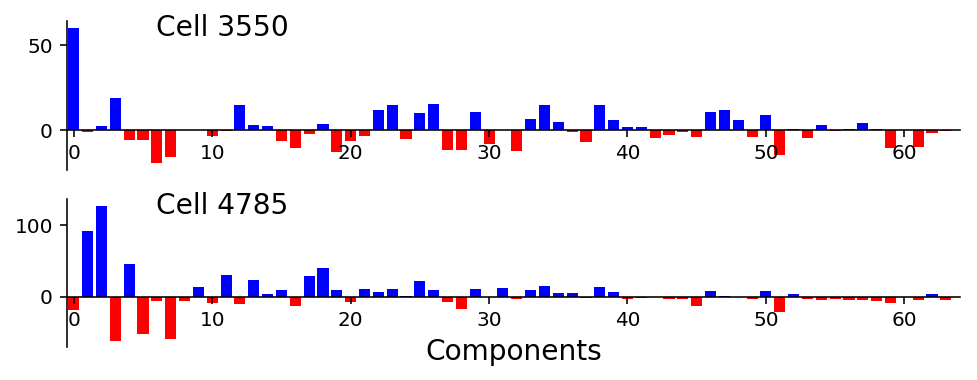

In [202]:
with loompy.connect(d + f + ".loom") as ds:
    # 4785, 3550
    pca = pcas[64]
    z = pca.pca.transform(data)
    gene_names = ds.ra.Gene[np.where(genes)[0]]
    plt.figure(figsize=(8, 3))
    ax=plt.subplot(211)
    plt.bar(np.arange(64), z[3550, :], color=["blue" if c > 0 else "red" for c in z[3550, :]])
    plt.text(0.1, 0.9, "Cell 3550", transform=ax.transAxes, size=14)
    print(gene_names[np.argsort(-pca.pca.components_[:, 0])][:5])
    print(gene_names[np.argsort(-pca.pca.components_[:, 3])][:5])
    print(gene_names[np.argsort(-pca.pca.components_[:, 6])][:5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))
    plt.xlim(-0.5,64)
    ax=plt.subplot(212)
    plt.bar(np.arange(64), z[4785, :],color=["blue" if c > 0 else "red" for c in z[4785, :]])
    print(gene_names[np.argsort(-pca.pca.components_[:, 1])][:5])
    print(gene_names[np.argsort(-pca.pca.components_[:, 2])][:5])
    print(gene_names[np.argsort(-pca.pca.components_[:, 7])][:5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position(('data', 0))
    plt.xlabel("Components", size=14)
    plt.xlim(-0.5,64)
    plt.text(0.1, 0.9, "Cell 4785", transform=ax.transAxes, size=14)
    plt.savefig("/Users/stelin/Dropbox (Linnarsson Group)/Linnarsson Group/Manuscripts/Mouse_development/Figs_parts/PCA_cells.pdf",dpi=144, bbox_inches='tight')

## A distance measure in HPF latent space
We treat the (per-cell) normalized HPF components as probability distributions. The Kullback-Leibler divergence
measures the number of additional bits of information in cell B, given cell A. However, the KL is not a proper
distance measure. We show that the closely related Jensen-Shannon distance (the square root of the Jensen Shannon
divergence) is empirically proportional to the log of the KLD. Hence we can use the JSD, a proper distance measure,
and calibrate it in terms of "bits of divergence" by transforming to the KLD.

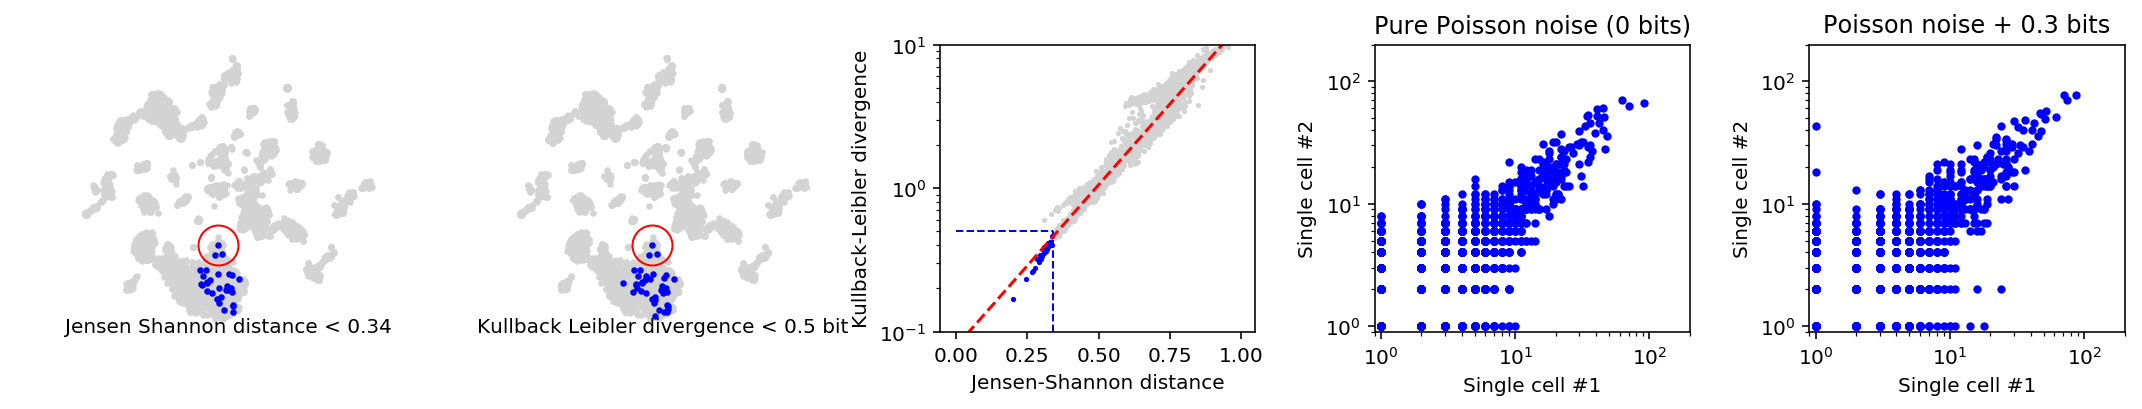

In [203]:
with loompy.connect(d + f + ".loom") as ds:
    cell = 3550 #4785, 3550
    jd_threshold = 0.34
    kl_threshold = 0.5
    plt.figure(figsize=(15, 3))
    hpf = hpfs[64]
    ax=plt.subplot(151)
    theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
    z1 = np.array([cg.jensen_shannon_distance(theta[cell, :], theta[i, :]) for i in range(n_cells)])
    cells = z1 < jd_threshold
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey",s=5)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c="blue",s=5,)
    plt.plot(ds.ca.TSNE[cell, 0], ds.ca.TSNE[cell, 1], marker="o", ms=20,mfc="none",c="red")
    plt.text(0.5, 0,  f"Jensen Shannon distance < {jd_threshold:.2}", ha="center",transform=ax.transAxes)
    plt.axis("off")
    ax=plt.subplot(152)
    z2 = np.array([entropy(theta[cell, :], theta[i, :], base=2) for i in range(n_cells)])
    cells = z2 <= kl_threshold
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey",s=5)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c="blue",s=5,cmap="viridis_r")
    plt.text(0.5, 0,  f"Kullback Leibler divergence < {kl_threshold} bit", ha="center",transform=ax.transAxes)
    plt.axis("off")
    plt.plot(ds.ca.TSNE[cell, 0], ds.ca.TSNE[cell, 1], marker="o", ms=20,mfc="none",c="red")
    ax=plt.subplot(153)
    plt.scatter(z1, z2, marker='.',s=10, color="lightgrey")
    plt.scatter(z1[(z1 < 0.34) & (z2 < 0.5)], z2[(z1 < 0.34) & (z2 < 0.5)], marker='.',s=10, color="blue")
    plt.plot((0, 1), (0.079, 14), color="red", linestyle="--")
    plt.hlines(kl_threshold, 0, jd_threshold, linestyle="--", color="blue",lw=1)
    plt.vlines(jd_threshold, 0.1, kl_threshold, linestyles="--", color="blue",lw=1)
    plt.xlabel("Jensen-Shannon distance")
    plt.ylabel("Kullback-Leibler divergence")
    plt.ylim((0.1, 10))
    ax.set_yscale("log")
    
    ax=plt.subplot(154)
    cells = np.random.choice(ds.shape[1], size=100)
    theta1 = hpfs[64].theta[cells]
    ppv = theta1 @ hpfs[64].beta.T
    plt.scatter(np.random.poisson(ppv), np.random.poisson(ppv), s=10, c="blue")
    ax.set_yscale("log")
    ax.set_xscale("log")
    plt.xlim(0.9, 200)
    plt.ylim(0.9, 200)
    plt.xlabel("Single cell #1")
    plt.ylabel("Single cell #2")
    plt.title("Pure Poisson noise (0 bits)")
    
    ax=plt.subplot(155)
    ppv1 = hpfs[64].theta[cells] @ hpfs[64].beta.T
    theta2 = hpfs[64].theta[cells]
    # Swap two top components, tends to give 0.5 bit difference
    theta2[:, [0, 1]] = theta2[:, [1, 0]]
    ppv2 = theta2 @ hpfs[64].beta.T
    plt.scatter(np.random.poisson(ppv1), np.random.poisson(ppv2), s=10, c="blue")
    ax.set_yscale("log")
    ax.set_xscale("log")
    plt.xlim(0.9, 200)
    plt.ylim(0.9, 200)
    plt.xlabel("Single cell #1")
    plt.ylabel("Single cell #2")
    plt.title(f"Poisson noise + {np.mean([entropy(t1, t2, base=2) for t1, t2 in zip(theta1, theta2)]):.1} bits")

    plt.tight_layout()
    

## Empirical formula

$$
Log2(KL) = 7.47 * JD -3.65
$$

In [204]:
np.polyfit(z1[(z2 != 0) & (z1 < 0.6)], np.log2(z2[(z2 != 0) & (z1 < 0.6)]), 1)

array([ 7.42179609, -3.56486092])

## Curse of dimensionality
How does the JSD to nearby cells vary as a function of the number of HPF components, compared to the distance to faraway cells?

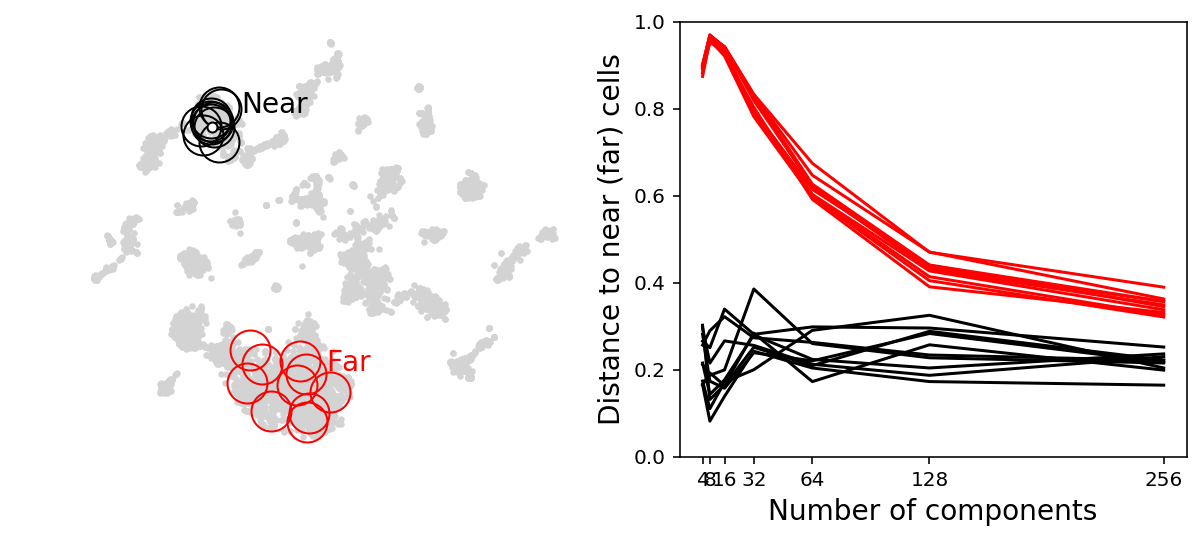

In [205]:
near = 4271
far = 2700
plt.figure(figsize=(10, 4))
ax=plt.subplot(121)
with loompy.connect(d + f + ".loom") as ds:
    rnn = ds.col_graphs.RNN
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey",s=5)
    plt.plot(ds.ca.TSNE[rnn.col[rnn.row == near][:10], 0], ds.ca.TSNE[rnn.col[rnn.row == near][:10], 1], marker="o", ms=20,mfc="none",c="black", lw=0)
    plt.plot(ds.ca.TSNE[np.arange(far, far + 10, 1), 0], ds.ca.TSNE[np.arange(far, far + 10, 1), 1], marker="o", ms=20,mfc="none",c="red", lw=0)
    plt.text(ds.ca.TSNE[near, 0] + 10, ds.ca.TSNE[near, 1]+5, f"Near", size=14, color="black")
    plt.text(ds.ca.TSNE[far, 0] + 10, ds.ca.TSNE[far, 1]+5, f"Far", size=14, color="red")
    plt.plot(ds.ca.TSNE[near, 0], ds.ca.TSNE[near, 1], ms=10, marker='.', mfc="white", c="black")
    plt.axis("off")
ax=plt.subplot(122)
for j in range(10):
    y = []
    for i in hpfs.keys():
        t = (hpfs[i].theta.T / hpfs[i].theta.sum(axis=1)).T
        y.append(cg.jensen_shannon_distance(t[near, :], t[rnn.col[rnn.row == near][j], :]))
    plt.plot([k for k in hpfs.keys()][1:], y[1:], color="black")
    plt.xticks([k for k in hpfs.keys()][1:])

for j in range(10):
    y = []
    for i in hpfs.keys():
        t = (hpfs[i].theta.T / hpfs[i].theta.sum(axis=1)).T
        y.append(cg.jensen_shannon_distance(t[near, :], t[far + j, :]))
    plt.plot([k for k in hpfs.keys()][1:], y[1:], color="red")
    plt.xticks([k for k in hpfs.keys()][1:])
plt.ylim(0,1)
plt.xlabel("Number of components", size=14)
_=plt.ylabel("Distance to near (far) cells", size=14)

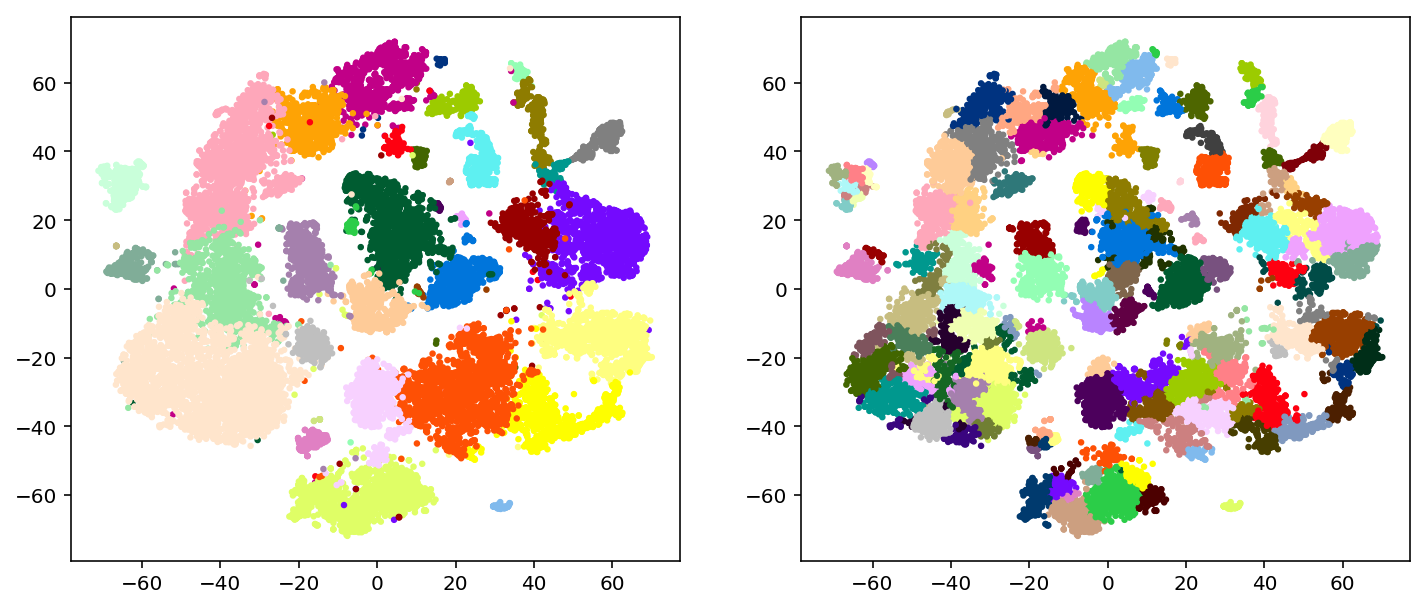

In [157]:
with loompy.connect(d + f + ".loom") as ds:
    rnn = ds.col_graphs.RNN
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=cgplot.colorize(ds.ca.Clusters),s=5)
    plt.subplot(122)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=cgplot.colorize(all_labels),s=5)

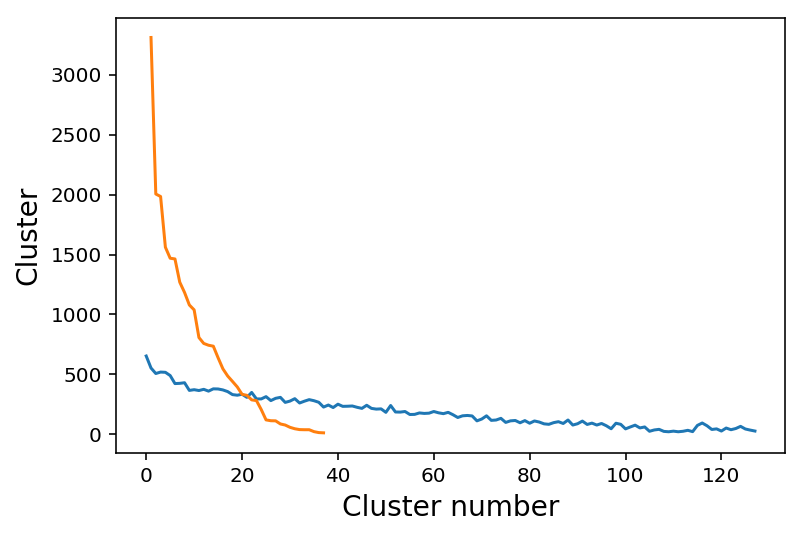

In [190]:
with loompy.connect(d + f + ".loom") as ds:
    plt.plot(np.arange(np.bincount(all_labels).shape[0]), np.bincount(all_labels))
    plt.plot(np.arange(np.bincount(ds.ca.Clusters).shape[0], 0, -1), sorted(np.bincount(ds.ca.Clusters)))
    plt.xlabel("Cluster number", size=14)
    plt.ylabel("Cluster", size=14)